# **Introduction**

Given the fact that most low-eviction neighborhoods exist in Staten Island and Queens, we have to ask if the building types play a role in influencing the likelihoods of evictions. If apartments are more prone to evictions, it means policy makers need to direct more attention to target apartment building intensive areas and have policies targeting at those neighborhoods.

The questions we asked and answered in this notebook include:

1. What percentage of evictions in a borough (Manhattan/Brooklyn) occur in apartments vs. houses?
2. Are apartments more likely to be evicted than houses in a given borough?
3. If so, are the odss the same? How do boroughs compare in eviction patterns?
4. Is the difference in eviction rates between apartments and houses statistically significant?


In [ ]:
brooklyn_evi_apt_rate = bk_evi_apt_count / bk_apt_count * 100
brooklyn_evi_house_rate = bk_evi_house_count / bk_house_count * 100
compare = pd.DataFrame({
    'man': [man_apt_evi_rate, man_house_evi_rate],
    'bk': [bk_apt_evi_rate, bk_house_evi_rate]
}, index=['apt', 'house'])

# this is basically a slice of the comprehensive dataframe we had towards the end, but this directly answers question 2.
# the odds are answered through the eviction rates throughout this notebook
# question 4 was answered through stratified chi-square test

,man,bk
apt,8.645172,3.729612
house,0.058824,0.325344


In [251]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as pltsa
import os
import io
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.stats.contingency_tables import StratifiedTable
from scipy.stats import chi2_contingency
# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [252]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
# display all columns
# avoid scientific digit
# pd.options.display.float_format = '{:.2f}'.format

In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [254]:
# link1 = 'bbl_evictions_311_svi_normal_times_svi.csv'
# link2 = 'bbl_evictions_311_svi_normal_svi.csv'
link1 = '/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_times_svi.csv'
# link2 = '/content/drive/My Drive/X999/bbl_evictions_311_svi_normal_svi.csv'
normal = pd.read_csv(link1)
# normal = pd.read_csv(link2)

In [255]:
normal.columns, normal.columns, normal.shape, normal.shape

(Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'zipcode', 'ejectment',
        ...
        'children_impacted_nta_per_1kpop', 'poverty_impacted_nta_per_1kpop',
        'disability_impacted_nta_per_1kpop',
        'unemployed_impacted_nta_per_1kpop', 'elderly_impacted_nta_per_1kpop',
        'bh_impacted_nta_per_1kpop', 'hburd_impacted_nta_per_1kpop',
        'average_year_eviction_per_building_nta(nta)',
        'average_5year_eviction_count_per_unit(building)', 'bh_pct'],
       dtype='object', length=108),
 Index(['primary_key', 'bbl', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'zipcode', 'ejectment',
        ...
        'children_impacted_nta_per_1kpop', 'poverty_impacted_nta_per_1kpop',
        'disability_impacted_nta_per_1kpop',
        'unemployed_impacted_nta_per_1kpop', 'elder

# **Step1: Building Data**

In [256]:
link3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
building = pd.read_csv(link3)

In [257]:
building.borough.unique()

array(['BK', 'QN', 'SI', 'MN', 'BX'], dtype=object)

In [258]:
building.building_category.unique(), building.building_type.unique()

(array(['single-family', 'primarily_res_with_mixed_use', 'walk-up',
        'two-family', 'condo-co-op', 'elevator'], dtype=object),
 array(['post-war', 'pre-war'], dtype=object))

In [259]:
man_bbl = building[building['borough'] == 'MN']
man_bbl.shape

(29264, 97)

In [260]:
bk_bbl = building[building['borough'] == 'BK']
bk_bbl.shape

(244611, 97)

In [261]:
bx_bbl = building[building['borough'] == 'BX']
bx_bbl.shape

(74875, 97)

In [262]:
quees_bbl = building[building['borough'] == 'QN']
quees_bbl.shape

(293494, 97)

In [263]:
si_bbl = building[building['borough'] == 'SI']
si_bbl.shape

(110375, 97)

In [264]:
man_house_bbl = man_bbl[man_bbl['building_category'].isin(['two-family', 'single-family'])]
man_apt_bbl = man_bbl[~man_bbl['building_category'].isin(['two-family', 'single-family'])]
man_house_count = man_house_bbl.shape[0]
man_apt_count = man_apt_bbl.shape[0]
man_house_bbl.shape, man_apt_bbl.shape, man_house_count, man_apt_count

((4080, 97), (25184, 97), 4080, 25184)

In [265]:
bk_house_bbl = bk_bbl[bk_bbl['building_category'].isin(['two-family', 'single-family'])]
bk_apt_bbl = bk_bbl[~bk_bbl['building_category'].isin(['two-family', 'single-family'])]
bk_house_count = bk_house_bbl.shape[0]
bk_apt_count = bk_apt_bbl.shape[0]
bk_house_bbl.shape, bk_apt_bbl.shape, bk_house_count, bk_apt_count

((155835, 97), (88776, 97), 155835, 88776)

In [266]:
bx_house_bbl = bx_bbl[bx_bbl['building_category'].isin(['two-family', 'single-family'])]
bx_apt_bbl = bx_bbl[~bx_bbl['building_category'].isin(['two-family', 'single-family'])]
bx_house_count = bx_house_bbl.shape[0]
bx_apt_count = bx_apt_bbl.shape[0]
bx_house_bbl.shape, bx_apt_bbl.shape, bx_house_count, bx_apt_count

((51422, 97), (23453, 97), 51422, 23453)

In [267]:
queen_house_bbl = quees_bbl[quees_bbl['building_category'].isin(['two-family', 'single-family'])]
queen_apt_bbl = quees_bbl[~quees_bbl['building_category'].isin(['two-family', 'single-family'])]
queen_house_count = queen_house_bbl.shape[0]
queen_apt_count = queen_apt_bbl.shape[0]
queen_house_bbl.shape, queen_apt_bbl.shape, queen_house_count, queen_apt_count

((246304, 97), (47190, 97), 246304, 47190)

In [268]:
si_house_bbl = si_bbl[si_bbl['building_category'].isin(['two-family', 'single-family'])]
si_apt_bbl = si_bbl[~si_bbl['building_category'].isin(['two-family', 'single-family'])]
si_house_count = si_house_bbl.shape[0]
si_apt_count = si_apt_bbl.shape[0]
si_house_bbl.shape, si_apt_bbl.shape, si_house_count, si_apt_count

((107256, 97), (3119, 97), 107256, 3119)

# **Turning building counts to unit counts**



In [269]:
# staten island
si_house_unit_mean = si_house_bbl.unitsres.mean()
si_house_unit_total = si_house_bbl.unitsres.sum()
si_apt_unit_mean = si_apt_bbl.unitsres.mean()
si_apt_unit_total = si_apt_bbl.unitsres.sum()

# manhattan
man_house_unit_mean = man_house_bbl.unitsres.mean()
man_house_unit_total = man_house_bbl.unitsres.sum()
man_apt_unit_mean = man_apt_bbl.unitsres.mean()
man_apt_unit_total = man_apt_bbl.unitsres.sum()

# brooklyn
bk_house_unit_mean = bk_house_bbl.unitsres.mean()
bk_house_unit_total = bk_house_bbl.unitsres.sum()
bk_apt_unit_mean = bk_apt_bbl.unitsres.mean()
bk_apt_unit_total = bk_apt_bbl.unitsres.sum()

# bronx
bx_house_unit_mean = bx_house_bbl.unitsres.mean()
bx_house_unit_total = bx_house_bbl.unitsres.sum()
bx_apt_unit_mean = bx_apt_bbl.unitsres.mean()
bx_apt_unit_total = bx_apt_bbl.unitsres.sum()

# queens
queen_house_unit_mean = queen_house_bbl.unitsres.mean()
queen_house_unit_total = queen_house_bbl.unitsres.sum()
queen_apt_unit_mean = queen_apt_bbl.unitsres.mean()
queen_apt_unit_total = queen_apt_bbl.unitsres.sum()

In [270]:
si_house_unit_rate = si_house_unit_total/ (si_house_unit_total + si_apt_unit_total)
si_apt_unit_rate = si_apt_unit_total/ (si_house_unit_total + si_apt_unit_total)
man_house_unit_rate = man_house_unit_total/ (man_house_unit_total + man_apt_unit_total)
man_apt_unit_rate = man_apt_unit_total/ (man_house_unit_total + man_apt_unit_total)
bk_house_unit_rate = bk_house_unit_total/ (bk_house_unit_total + bk_apt_unit_total)
bk_apt_unit_rate = bk_apt_unit_total/ (bk_house_unit_total + bk_apt_unit_total)
bx_house_unit_rate = bx_house_unit_total/ (bx_house_unit_total + bx_apt_unit_total)
bx_apt_unit_rate = bx_apt_unit_total/ (bx_house_unit_total + bx_apt_unit_total)
queen_house_unit_rate = queen_house_unit_total/ (queen_house_unit_total + queen_apt_unit_total)
queen_apt_unit_rate = queen_apt_unit_total / (queen_house_unit_total + queen_apt_unit_total)

In [271]:
si_house_unit_rate, si_apt_unit_rate, man_house_unit_rate, man_apt_unit_rate, bk_house_unit_rate, bk_apt_unit_rate, bx_house_unit_rate, bx_apt_unit_rate, \
queen_house_unit_rate, queen_apt_unit_rate

(np.float64(0.8070635437380118),
 np.float64(0.19293645626198813),
 np.float64(0.007638582390609151),
 np.float64(0.9923614176093909),
 np.float64(0.2522953694029926),
 np.float64(0.7477046305970074),
 np.float64(0.15584868537027805),
 np.float64(0.8441513146297219),
 np.float64(0.42049744927657),
 np.float64(0.57950255072343))

In [272]:
si_house_unit_total, si_apt_unit_total, man_house_unit_total, man_apt_unit_total, bk_house_unit_total, bk_apt_unit_total, bx_house_unit_total, bx_apt_unit_total, \
queen_house_unit_total, queen_apt_unit_total

(np.int64(137589),
 np.int64(32892),
 np.int64(5919),
 np.int64(768963),
 np.int64(250661),
 np.int64(742861),
 np.int64(82220),
 np.int64(445343),
 np.int64(343144),
 np.int64(472899))

# **Step 2: normal-Evictions**

In [273]:
normal.building_category.unique()

array(['walk-up', 'two-family', 'condo-co-op', 'elevator',
       'single-family', 'primarily_res_with_mixed_use'], dtype=object)

In [274]:
normal_evi_building = normal.groupby('bin').agg(
    count_primary_key=('primary_key', 'count'),
    first_unitsres=('unitsres', 'first')
).reset_index()
normal_evi_building.rename(columns={'count_primary_key': 'eviction_count', 'first_unitsres': 'unitsres'}, inplace=True)
normal_evi_building['evi_unit_rate'] = normal_evi_building['eviction_count']/normal_evi_building['unitsres']
normal_evi_building

,bin,eviction_count,unitsres,evi_unit_rate
0,1000793,9,397.0,0.022670
1,1000810,2,237.0,0.008439
2,1000816,1,298.0,0.003356
3,1000826,1,435.0,0.002299
4,1000828,8,476.0,0.016807
...,...,...,...,...
30371,5172106,1,2.0,0.500000
30372,5172107,1,2.0,0.500000
30373,5172108,1,104.0,0.009615
30374,5172109,1,20.0,0.050000


In [275]:
normal_evi_building = normal_evi_building[['bin', 'eviction_count', 'evi_unit_rate']]
normal_evi_building.sort_values(by='eviction_count', ascending=False)

,bin,eviction_count,evi_unit_rate
13457,2127134,74,0.044740
12866,2113629,67,0.040508
22089,3326600,66,0.171429
12451,2093973,61,0.036880
21613,3253907,49,0.146707
...,...,...,...
10,1001014,1,0.002941
7,1000844,1,0.333333
6,1000831,1,0.004950
3,1000826,1,0.002299


In [276]:
normal_1000793 = normal[normal['bin'] == 2127134]
normal_1000793.shape

(74, 108)

In [277]:
0.44740/5, 74/5

(0.08948, 14.8)

In [278]:
# normal_2127134 = normal[normal['bin'] == 2127134]
# normal_2127134

In [279]:
normal = normal.merge(normal_evi_building, on='bin')

In [280]:
# Stop

In [281]:
normal.head()

,primary_key,bbl,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,nta,year,month_year,geometry,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white,invalid_zip,svi_quartile,svi_group,air_quality,animal_issues,appliances,building_exterior,doors_windows,electrical_issues,elevator_issues,floors_stairs,general_complaints,graffiti_posting,heat_hot_water,homeless_issues,noise_complaints,other_issues,pest_issues,plumbing_issues,police_matters,public_nuisance,safety_concerns,sanitation_issues,walls_ceilings,total_complaints,average_year_eviction_count_per_unit(building),average_year_eviction_count(building),average_year_eviction_count_per_nta(nta),evictions_per_nta_1kpop(nta),buildings_affected_per_nta,unit_per_nta,evictions_per_1kunit_nta_1kpop(nta),children_impacted_nta_per_1kpop,poverty_impacted_nta_per_1kpop,disability_impacted_nta_per_1kpop,unemployed_impacted_nta_per_1kpop,elderly_impacted_nta_per_1kpop,bh_impacted_nta_per_1kpop,hburd_impacted_nta_per_1kpop,average_year_eviction_per_building_nta(nta),average_5year_eviction_count_per_unit(building),bh_pct,eviction_count,evi_unit_rate
0,*308072/22_5865,3037420029,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.672121,-73.891105,5.0,37.0,1152.0,3083989,East New York,2024,2024-12,POINT (-73.891105 40.672121),1930.0,C0,3.0,3.0,356 MILLER LLC,2700.0,pre-war,walk-up,False,low-rise,"Pre-1947, pre-rent-control","1921–1930, Art Deco Skyscrapers","1930-1945, great depression and WWII",3-5 units,True,small,Q3 (50-75%),1930-1939,11207,96801.0,0.9788,0.9140,0.9808,0.9812,0.9839,33.9,11.1,19.1,6.0,13.8,22.5,13.8,5.3,57.8,9.1,44.7,55.9,32.8,1.5,0.0,0.0,2.9,1.6,94.7,5.3,False,Q3,medium-high,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0,19.0,0.266667,0.8,266.0,2.747905,725,2175.0,1.263405,0.618279,0.931540,0.379211,0.305018,0.379211,2.437392,1.228314,3.668966,1.333333,88.7,4,1.333333
1,*313639/23_5202,3057940012,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,-74.011883,7.0,38.0,118.0,3143881,Sunset Park East,2024,2024-03,POINT (-74.011883 40.635941),1920.0,B2,2.0,2.0,"A.R.M. PARKING, LLC",1204.0,pre-war,two-family,False,low-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",2-unit,True,very small,Q1 (smallest 25%),1920-1929,11220,93008.0,0.9885,0.7635,0.9594,0.9179,0.9662,37.5,7.5,37.9,11.6,13.1,25.4,8.4,40.2,61.7,23.7,43.6,1.7,40.9,40.7,0.4,0.0,1.2,0.2,85.0,15.0,False,Q3,medium-high,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,0.300000,0.6,38.0,0.408567,136,272.0,1.502085,0.103776,0.153213,0.034320,0.030643,0.053522,0.174050,0.178135,2.794118,1.500000,42.6,3,1.500000
2,*324973/22_5308,3057820030,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,40.640008,-74.017068,7.0,38.0,122.0,3143435,Sunset Park West,2024,2024-08,POINT (-74.017068 40.640008),1907.0,C3,4.0,4.0,"LIN, RONG LAN",4800.0,pre-war,walk-up,False,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",3-5 units,False,medium-small,Q4 (largest 25%),1900-1909,11220,93008.0,0.9885,0.7635,0.9594,0.9179,0.9662,37.5,7.5,37.9,11.6,13.1,25.4,8.4,40.2,61.7,23.7,43.6,1.7,40.9,40.7,0.4,0.0,1.2,0.2,85.0,15.0,False,Q3,medium-high,0

In [282]:
# normal.drop(columns=['average_year_eviction_unit_rate(building)'], inplace=True)

### **Note: the first two rates should add up to 100, but the last two do not have to. The first two resulted rates mean out of all the evictions (per borough), how many percentages of them happened in houses or apartments, respectively. The second pair of rates answer the question: out of all the apartments/house, how many percentages of them had evictions per borough per year**

## **2.1 Manhattan**

In [283]:
manhattan_evi = normal[normal['borough'] == 'MANHATTAN']
manhattan_evi.shape

(10898, 110)

In [284]:
manhattan_evi_count = manhattan_evi.shape[0]/5
manhattan_evi_count
# on average, how many evictions per year does manhattan have

2179.6

In [285]:
man_evi_house = manhattan_evi[manhattan_evi['building_category'].isin(['two-family', 'single-family'])]
man_evi_apt= manhattan_evi[~manhattan_evi['building_category'].isin(['two-family', 'single-family'])]
man_evi_house_count = man_evi_house.shape[0]/5
man_evi_apt_count = man_evi_apt.shape[0]/5
man_evi_house.shape, man_evi_apt.shape, man_evi_house_count, man_evi_apt_count

((12, 110), (10886, 110), 2.4, 2177.2)

In [286]:
man_apt_count/man_bbl.shape[0], man_house_count/man_bbl.shape[0], man_bbl.shape[0],

(0.8605795516675779, 0.1394204483324221, 29264)

In [287]:
man_evi_house_rate = man_evi_house_count/manhattan_evi_count*100
man_evi_apt_rate = man_evi_apt_count/manhattan_evi_count*100
man_house_evi_rate = man_evi_house_count/man_house_count*100
man_apt_evi_rate = man_evi_apt_count / man_apt_count*100
man_evi_house_rate, man_evi_apt_rate, man_house_evi_rate, man_apt_evi_rate,  0.08645171537484116/0.000588235294117647

(0.11011194714626536,
 99.88988805285372,
 0.0588235294117647,
 8.645171537484115,
 146.96791613723)

### **0.1% of evictions in manhattan happened in houses. 99% of evictions in manhattan happened in apartments. 0.05% of manhattan houses had evcitions. 8.645 of manhattan apts had evictions. This suggests if you live in apartments, you are ~147X more likely to be evicted than living in houses in Manhattan.**

## **Manhattan Units**

In [288]:
man_evi_house = manhattan_evi[manhattan_evi['building_category'].isin(['two-family', 'single-family'])]
man_evi_apt= manhattan_evi[~manhattan_evi['building_category'].isin(['two-family', 'single-family'])]
man_evi_house_unit_count = man_evi_house.shape[0]/5
man_evi_apt_unit_count = man_evi_apt.shape[0]/5
man_evi_house.shape, man_evi_apt.shape, man_evi_house_count, man_evi_apt_count

((12, 110), (10886, 110), 2.4, 2177.2)

## **2.2 Brooklyn**

In [289]:
brooklyn_evi = normal[normal['borough'] == 'BROOKLYN']
brooklyn_evi.shape

(19090, 110)

In [290]:
brooklyn_evi_count = brooklyn_evi.shape[0]/5
brooklyn_evi_count

3818.0

In [291]:
bk_evi_house = brooklyn_evi[brooklyn_evi['building_category'].isin(['two-family', 'single-family'])]
bk_evi_apt = brooklyn_evi[~brooklyn_evi['building_category'].isin(['two-family', 'single-family'])]
bk_evi_house_count = bk_evi_house.shape[0]/5
bk_evi_apt_count = bk_evi_apt.shape[0]/5
bk_evi_house.shape, bk_evi_apt.shape, bk_evi_house_count, bk_evi_apt_count

((2535, 110), (16555, 110), 507.0, 3311.0)

In [292]:
bk_evi_house_rate = bk_evi_house_count/brooklyn_evi_count*100
bk_evi_apt_rate = bk_evi_apt_count/brooklyn_evi_count*100
bk_house_evi_rate = bk_evi_house_count/bk_house_count*100
bk_apt_evi_rate = bk_evi_apt_count / bk_apt_count*100
bk_evi_house_rate, bk_evi_apt_rate, bk_house_evi_rate, bk_apt_evi_rate, bk_apt_evi_rate/bk_house_evi_rate

(13.279203771608172,
 86.72079622839183,
 0.32534411396669555,
 3.7296116067405607,
 11.46359023148748)

### **these stats suggest about 13.27 % of the evictions in BK happened in houses. About 86.72% of the evictions in BK happened in apartments. About 0.325% of bk houses experienced evictions. About 3.729% of bk apartments experinced evictions. These are all per year on average stats. This suggests that if you live in apartments, you are 11.46 times more likely to get evicted than living in apartments.**

## **Brooklyn unit**

In [293]:
bk_evi_house = brooklyn_evi[brooklyn_evi['building_category'].isin(['two-family', 'single-family'])]
bk_evi_apt = brooklyn_evi[~brooklyn_evi['building_category'].isin(['two-family', 'single-family'])]
bk_evi_house_unit_count = bk_evi_house.shape[0]/5
bk_evi_apt_unit_count = bk_evi_apt.shape[0]/5
bk_evi_house.shape, bk_evi_apt.shape, bk_evi_house_unit_count, bk_evi_apt_unit_count

((2535, 110), (16555, 110), 507.0, 3311.0)

## **2.3 Queens**

In [294]:
queens_evi = normal[normal['borough'] == 'QUEENS']
queens_evi.shape

(9831, 110)

In [295]:
queens_evi_count = queens_evi.shape[0]/5
queens_evi_count

1966.2

In [296]:
queens_evi_house = queens_evi[queens_evi['building_category'].isin(['two-family', 'single-family'])]
queens_evi_apt = queens_evi[~queens_evi['building_category'].isin(['two-family', 'single-family'])]
queens_evi_house_count = queens_evi_house.shape[0]/5
queens_evi_apt_count = queens_evi_apt.shape[0]/5
queens_evi_house.shape, queens_evi_apt.shape, queens_evi_house_count, queens_evi_apt_count

((2663, 110), (7168, 110), 532.6, 1433.6)

In [297]:
queens_evi_house_rate = queens_evi_house_count/queens_evi_count*100
queens_evi_apt_rate = queens_evi_apt_count/queens_evi_count*100
queens_house_evi_rate = queens_evi_house_count/queen_house_count*100
queens_apt_evi_rate = queens_evi_apt_count / queen_apt_count*100
queens_evi_house_rate, queens_evi_apt_rate, queens_house_evi_rate, queens_apt_evi_rate, queens_apt_evi_rate/queens_house_evi_rate

(27.08778354185739,
 72.91221645814261,
 0.21623684552423023,
 3.0379317652044926,
 14.04909398229304)

### **about 27.08% of the evictions happened in queens happened in houses. About 72.91% of the evictions happened in queens happened in aparts. About 0.2% of houses in queens had evictions per year. About 14.05% of apartments in queens had evictions per year.**

In [298]:
queens_evi_house = queens_evi[queens_evi['building_category'].isin(['two-family', 'single-family'])]
queens_evi_apt = queens_evi[~queens_evi['building_category'].isin(['two-family', 'single-family'])]
queens_evi_house_unit_count = queens_evi_house.shape[0]/5
queens_evi_apt_unit_count = queens_evi_apt.shape[0]/5
queens_evi_house.shape, queens_evi_apt.shape, queens_evi_house_unit_count, queens_evi_apt_unit_count

((2663, 110), (7168, 110), 532.6, 1433.6)

## **2.4 Staten Island**

In [299]:
si_evi = normal[normal['borough'] == 'STATEN ISLAND']
si_evi.shape

(1940, 110)

In [300]:
si_evi_count = si_evi.shape[0]/5
si_evi_count

388.0

In [301]:
si_evi_house = si_evi[si_evi['building_category'].isin(['two-family', 'single-family'])]
si_evi_apt = si_evi[~si_evi['building_category'].isin(['two-family', 'single-family'])]
si_evi_house_count = si_evi_house.shape[0]/5
si_evi_apt_count = si_evi_apt.shape[0]/5
si_evi_house.shape, si_evi_apt.shape, si_evi_house_count, si_evi_apt_count

((801, 110), (1139, 110), 160.2, 227.8)

In [302]:
si_evi_house_rate = si_evi_house_count/si_evi_count*100
si_evi_apt_rate = si_evi_apt_count/si_evi_count*100
si_house_evi_rate = si_evi_house_count/si_house_count*100
si_apt_evi_rate = si_evi_apt_count / si_apt_count*100
si_evi_house_rate, si_evi_apt_rate, si_house_evi_rate, si_apt_evi_rate, si_apt_evi_rate/si_house_evi_rate
# the first two should add up to 1, but the last two do not have to

(41.28865979381443,
 58.71134020618557,
 0.14936227343924816,
 7.303622956075666,
 48.898713094684865)

### **about 41.29% of the evictions happened in si happened in houses. About 58.71% of the evictions happened in si happened in aparts. About 0.015% of houses in si had evictions per year. About 48.90% of apartments in si had evictions per year.**

In [303]:
si_evi_house = si_evi[si_evi['building_category'].isin(['two-family', 'single-family'])]
si_evi_apt = si_evi[~si_evi['building_category'].isin(['two-family', 'single-family'])]
si_evi_house_unit_count = si_evi_house.shape[0]/5
si_evi_apt_unit_count = si_evi_apt.shape[0]/5
si_evi_house.shape, si_evi_apt.shape, si_evi_house_unit_count, si_evi_apt_unit_count

((801, 110), (1139, 110), 160.2, 227.8)

## **2.5 Bronx**

In [304]:
bx_evi = normal[normal['borough'] == 'BRONX']
bx_evi.shape

(24638, 110)

In [305]:
bx_evi_count = bx_evi.shape[0]/5
bx_evi_count

4927.6

In [306]:
bx_evi_house = bx_evi[bx_evi['building_category'].isin(['two-family', 'bxngle-family'])]
bx_evi_apt = bx_evi[~bx_evi['building_category'].isin(['two-family', 'bxngle-family'])]
bx_evi_house_count = bx_evi_house.shape[0]/5
bx_evi_apt_count = bx_evi_apt.shape[0]/5
bx_evi_house.shape, bx_evi_apt.shape, bx_evi_house_count, bx_evi_apt_count

((1256, 110), (23382, 110), 251.2, 4676.4)

In [307]:
bx_evi_house_rate = bx_evi_house_count/bx_evi_count*100
bx_evi_apt_rate = bx_evi_apt_count/bx_evi_count*100
bx_house_evi_rate = bx_evi_house_count/bx_house_count*100
bx_apt_evi_rate = bx_evi_apt_count / bx_apt_count*100
bx_evi_house_rate, bx_evi_apt_rate, bx_house_evi_rate, bx_apt_evi_rate, bx_apt_evi_rate/bx_house_evi_rate

(5.097816381199772,
 94.90218361880022,
 0.4885068647660534,
 19.939453374834777,
 40.817140582832565)

### **about 5.10% of the evictions happened in bx happened in houses. About 94.90% of the evictions happened in bx happened in aparts. About 0.200% of houses in bx had evictions per year. About 40.82% of apartments in bx had evictions per year.**

Let's put together some neat dataframes for comparisons and potentially for excel and arcgis.

# **Step 3: createing dataframes for bette readability**

## **3.1 A simple summary df (for excel) chart**

In [308]:
all_borough_data = {'borough': ['manhattan', 'brooklyn', 'queens', 'staten island', 'bronx'],
        'evictions_happened_in_house_rates': [man_evi_house_rate, bk_evi_house_rate, queens_evi_house_rate, si_evi_house_rate, bx_evi_house_rate],
        'eviction_happened_in_apt_rates': [man_evi_apt_rate, bk_evi_apt_rate, queens_evi_apt_rate, si_evi_apt_rate, bx_evi_apt_rate],
        'house_that_had_eviction_rates': [man_house_evi_rate, bk_house_evi_rate, queens_house_evi_rate, si_house_evi_rate, bx_house_evi_rate],
        'apt_that_had_eviction_rates': [man_apt_evi_rate, bk_apt_evi_rate, queens_apt_evi_rate, si_apt_evi_rate, bx_apt_evi_rate]}

summary_df  = pd.DataFrame(all_borough_data)
summary_df
# this can be used in one or two excel chart

,borough,evictions_happened_in_house_rates,eviction_happened_in_apt_rates,house_that_had_eviction_rates,apt_that_had_eviction_rates
0,manhattan,0.110112,99.889888,0.058824,8.645172
1,brooklyn,13.279204,86.720796,0.325344,3.729612
2,queens,27.087784,72.912216,0.216237,3.037932
3,staten island,41.288660,58.711340,0.149362,7.303623
4,bronx,5.097816,94.902184,0.488507,19.939453


## **3.2 Simple building and eviction count/boros (pie) chart (for excel)**

In [309]:
borough_evi_building_total = {
    'borough': ['manhattan', 'brooklyn', 'queens', 'staten island', 'bronx'],
    'evictions_total_per_year': [manhattan_evi_count, brooklyn_evi_count, queens_evi_count, si_evi_count, bx_evi_count],
    'building_total': [man_bbl.shape[0], bk_bbl.shape[0], quees_bbl.shape[0], si_bbl.shape[0], bx_bbl.shape[0]],
    'evictions_out_of_all_building_boro_pct': [manhattan_evi_count/man_bbl.shape[0]*100, brooklyn_evi_count/bk_bbl.shape[0]*100, queens_evi_count/quees_bbl.shape[0]*100, si_evi_count/si_bbl.shape[0]*100, bx_evi_count/bx_bbl.shape[0]*100]
}

borough_evi_total_df = pd.DataFrame(borough_evi_building_total)
borough_evi_total_df
# another candidate for excel pie chart

,borough,evictions_total_per_year,building_total,evictions_out_of_all_building_boro_pct
0,manhattan,2179.6,29264,7.448059
1,brooklyn,3818.0,244611,1.560846
2,queens,1966.2,293494,0.669929
3,staten island,388.0,110375,0.351529
4,bronx,4927.6,74875,6.581102


In [310]:
all_apt = man_apt_count + bk_apt_count + queen_apt_count + si_apt_count + bx_apt_count
all_house = man_house_count + bk_house_count + queen_house_count + si_house_count + bx_house_count
all_apt_evi = man_evi_apt_count + bk_evi_apt_count + queens_evi_apt_count + si_evi_apt_count + bx_evi_apt_count
all_house_evi = man_evi_house_count + bk_evi_house_count + queens_evi_house_count + si_evi_house_count + bx_evi_house_count
all_apt, all_house, all_apt_evi, all_house_evi

(187722, 564897, 11826.0, 1453.4)

In [311]:
all_apt_evi_rate = all_apt_evi/all_apt*100
all_house_evi_rate = all_house_evi/all_house*100
all_apt_evi_rate, all_house_evi_rate
# overall, about 6.30% of apartment buildings had evictions, and about 2.57% of houses had evictoions across all boroughs

(6.2997411065298685, 0.25728584148968753)

In [312]:
apt = building[building['building_category'].isin(['two-family', 'single-family'])]
house = building[~building['building_category'].isin(['two-family', 'single-family'])]
apt.shape[0], house.shape[0]
# another way to look at this. it was correct

(564897, 187722)

In [313]:
all_evi_count = normal.shape[0]/5
all_evi_count

13279.4

In [314]:
all_evi_count = all_apt_evi + all_house_evi
all_evi_rate = all_evi_count/building.shape[0]*100
all_evi_count, all_evi_rate
# another way, correct

(13279.4, 1.7644252935416191)

In [315]:
evi_count_data = {
    'all_building_count': [building.shape[0]],
    'all_eviction_count': [all_evi_count],
    'all_eviction_rate': [all_evi_rate],
    'all_apt': [all_apt],
    'all_house': [all_house],
    'all_apt_rate': [all_apt/building.shape[0]*100],
    'all_house_rate': [all_house/building.shape[0]*100],
    'all_apt_evi_affected': [all_apt_evi],
    'all_house_evi_affected': [all_house_evi],
    'all_evi_apt_rate': [all_apt_evi/all_evi_count*100],
    'all_evi_house_rate': [all_house_evi/all_evi_count*100],
    'all_apt_evi_affected_rate': [all_apt_evi_rate],
    'all_house_evi_affected_rate': [all_house_evi_rate]
}

evi_count_df = pd.DataFrame(evi_count_data)
evi_count_df

,all_building_count,all_eviction_count,all_eviction_rate,all_apt,all_house,all_apt_rate,all_house_rate,all_apt_evi_affected,all_house_evi_affected,all_evi_apt_rate,all_evi_house_rate,all_apt_evi_affected_rate,all_house_evi_affected_rate
0,752619,13279.4,1.764425,187722,564897,24.942501,75.057499,11826.0,1453.4,89.055228,10.944772,6.299741,0.257286


In [316]:
man_evi_count_data = {
    'man_building_count': [man_bbl.shape[0]],
    'man_eviction_count': [manhattan_evi_count],
    'man_eviction_rate': [manhattan_evi_count/man_bbl.shape[0]*100],
    'man_apt': [man_apt_count],
    'man_house': [man_house_count],
    'man_apt_rate': [man_apt_count/man_bbl.shape[0]*100],
    'man_house_rate': [man_house_count/man_bbl.shape[0]*100],
    'man_apt_evi_affected': [man_evi_apt_count],
    'man_house_evi_affected': [man_evi_house_count],
    'man_evi_apt_rate': [man_evi_apt_rate],
    'man_evi_house_rate': [man_evi_house_rate],
    'man_apt_evi_affected_rate': [man_apt_evi_rate],
    'man_house_evi_affected_rate': [man_house_evi_rate]
}

man_evi_count_df = pd.DataFrame(man_evi_count_data)
man_evi_count_df

,man_building_count,man_eviction_count,man_eviction_rate,man_apt,man_house,man_apt_rate,man_house_rate,man_apt_evi_affected,man_house_evi_affected,man_evi_apt_rate,man_evi_house_rate,man_apt_evi_affected_rate,man_house_evi_affected_rate
0,29264,2179.6,7.448059,25184,4080,86.057955,13.942045,2177.2,2.4,99.889888,0.110112,8.645172,0.058824


In [317]:
bk_evi_count_data = {
    'bk_building_count': [bk_bbl.shape[0]],
    'bk_eviction_count': [brooklyn_evi_count],
    'bk_eviction_rate': [brooklyn_evi_count/bk_bbl.shape[0]*100],
    'bk_apt': [bk_apt_count],
    'bk_house': [bk_house_count],
    'bk_apt_rate': [bk_apt_count/bk_bbl.shape[0]*100],
    'bk_house_rate': [bk_house_count/bk_bbl.shape[0]*100],
    'bk_apt_evi_affected': [bk_evi_apt_count],
    'bk_house_evi_affected': [bk_evi_house_count],
    'bk_evi_apt_rate': [bk_evi_apt_rate],
    'bk_evi_house_rate': [bk_evi_house_rate],
    'bk_apt_evi_affected_rate': [bk_apt_evi_rate],
    'bk_house_evi_affected_rate': [bk_house_evi_rate]
}

bk_evi_count_df = pd.DataFrame(bk_evi_count_data)
bk_evi_count_df

,bk_building_count,bk_eviction_count,bk_eviction_rate,bk_apt,bk_house,bk_apt_rate,bk_house_rate,bk_apt_evi_affected,bk_house_evi_affected,bk_evi_apt_rate,bk_evi_house_rate,bk_apt_evi_affected_rate,bk_house_evi_affected_rate
0,244611,3818.0,1.560846,88776,155835,36.292726,63.707274,3311.0,507.0,86.720796,13.279204,3.729612,0.325344


In [318]:
bx_evi_count_data = {
    'bx_building_count': [bx_bbl.shape[0]],
    'bx_eviction_count': [bx_evi_count],
    'bx_eviction_rate': [bx_evi_count/bx_bbl.shape[0]*100],
    'bx_apt': [bx_apt_count],
    'bx_house': [bx_house_count],
    'bx_apt_rate': [bx_apt_count/bx_bbl.shape[0]*100],
    'bx_house_rate': [bx_house_count/bx_bbl.shape[0]*100],
    'bx_apt_evi_affected': [bx_evi_apt_count],
    'bx_house_evi_affected': [bx_evi_house_count],
    'bx_evi_apt_rate': [bx_evi_apt_rate],
    'bx_evi_house_rate': [bx_evi_house_rate],
    'bx_apt_evi_affected_rate': [bx_apt_evi_rate],
    'bx_house_evi_affected_rate': [bx_house_evi_rate]
}

bx_evi_count_df = pd.DataFrame(bx_evi_count_data)
bx_evi_count_df

,bx_building_count,bx_eviction_count,bx_eviction_rate,bx_apt,bx_house,bx_apt_rate,bx_house_rate,bx_apt_evi_affected,bx_house_evi_affected,bx_evi_apt_rate,bx_evi_house_rate,bx_apt_evi_affected_rate,bx_house_evi_affected_rate
0,74875,4927.6,6.581102,23453,51422,31.322871,68.677129,4676.4,251.2,94.902184,5.097816,19.939453,0.488507


In [319]:
queens_evi_count_data = {
    'queens_building_count': [quees_bbl.shape[0]],
    'queens_eviction_count': [queens_evi_count],
    'queens_eviction_rate': [queens_evi_count/quees_bbl.shape[0]*100],
    'queens_apt': [queen_apt_count],
    'queens_house': [queen_house_count],
    'queens_apt_rate': [queen_apt_count/quees_bbl.shape[0]*100],
    'queens_house_rate': [queen_house_count/quees_bbl.shape[0]*100],
    'queens_apt_evi_affected': [queens_evi_apt_count],
    'queens_house_evi_affected': [queens_evi_house_count],
    'queens_evi_apt_rate': [queens_evi_apt_rate],
    'queens_evi_house_rate': [queens_evi_house_rate],
    'queens_apt_evi_affected_rate': [queens_apt_evi_rate],
    'queens_house_evi_affected_rate': [queens_house_evi_rate]
}

queens_evi_count_df = pd.DataFrame(queens_evi_count_data)
queens_evi_count_df

,queens_building_count,queens_eviction_count,queens_eviction_rate,queens_apt,queens_house,queens_apt_rate,queens_house_rate,queens_apt_evi_affected,queens_house_evi_affected,queens_evi_apt_rate,queens_evi_house_rate,queens_apt_evi_affected_rate,queens_house_evi_affected_rate
0,293494,1966.2,0.669929,47190,246304,16.078693,83.921307,1433.6,532.6,72.912216,27.087784,3.037932,0.216237


In [320]:
si_evi_count_data = {
    'si_building_count': [si_bbl.shape[0]],
    'si_eviction_count': [si_evi_count],
    'si_eviction_rate': [si_evi_count/si_bbl.shape[0]*100],
    'si_apt': [si_apt_count],
    'si_house': [si_house_count],
    'si_apt_rate': [si_apt_count/si_bbl.shape[0]*100],
    'si_house_rate': [si_house_count/si_bbl.shape[0]*100],
    'si_apt_evi_affected': [si_evi_apt_count],
    'si_house_evi_affected': [si_evi_house_count],
    'si_evi_apt_rate': [si_evi_apt_rate],
    'si_evi_house_rate': [si_evi_house_rate],
    'si_apt_evi_affected_rate': [si_apt_evi_rate],
    'si_house_evi_affected_rate': [si_house_evi_rate]
}

si_evi_count_df = pd.DataFrame(si_evi_count_data)
si_evi_count_df

,si_building_count,si_eviction_count,si_eviction_rate,si_apt,si_house,si_apt_rate,si_house_rate,si_apt_evi_affected,si_house_evi_affected,si_evi_apt_rate,si_evi_house_rate,si_apt_evi_affected_rate,si_house_evi_affected_rate
0,110375,388.0,0.351529,3119,107256,2.825821,97.174179,227.8,160.2,58.71134,41.28866,7.303623,0.149362


In [321]:
si_df = si_evi_count_df.rename(columns = {
                                  'si_building_count': "building_count",
                                  'si_eviction_count': "eviction_count",
                                  'si_eviction_rate': "eviction_rate",
                                  'si_apt': "apt_count",
                                  'si_house': "house_count",
                                  'si_apt_rate': "apt_rate",
                                  'si_house_rate': "house_rate",
                                  'si_apt_evi_affected': "apt_evi_affected",
                                  'si_house_evi_affected': "house_evi_affected",
                                  'si_evi_apt_rate': "apt_evi_rate",
                                  'si_evi_house_rate': "house_evi_rate",
                                  'si_apt_evi_affected_rate': "apt_evi_affected_rate",
                                  'si_house_evi_affected_rate': "house_evi_affected_rate"
                                  })
man_df = man_evi_count_df.rename(columns = {
                                  'man_building_count': "building_count",
                                  'man_eviction_count': "eviction_count",
                                  'man_eviction_rate': "eviction_rate",
                                  'man_apt': "apt_count",
                                  'man_house': "house_count",
                                  'man_apt_rate': "apt_rate",
                                  'man_house_rate': "house_rate",
                                  'man_apt_evi_affected': "apt_evi_affected",
                                  'man_house_evi_affected': "house_evi_affected",
                                  'man_evi_apt_rate': "apt_evi_rate"
                                  ,'man_evi_house_rate': "house_evi_rate",
                                  'man_apt_evi_affected_rate': "apt_evi_affected_rate",
                                  'man_house_evi_affected_rate': "house_evi_affected_rate"
                                  })
all_df = evi_count_df.rename(columns = {
                                  'all_building_count': "building_count",
                                  'all_eviction_count': "eviction_count",
                                  'all_eviction_rate': "eviction_rate",
                                  'all_apt': "apt_count",
                                  'all_house': "house_count",
                                  'all_apt_rate': "apt_rate",
                                  'all_house_rate': "house_rate",
                                  'all_apt_evi_affected': "apt_evi_affected",
                                  'all_house_evi_affected': "house_evi_affected",
                                  'all_evi_apt_rate': "apt_evi_rate",
                                  'all_evi_house_rate': "house_evi_rate",
                                  'all_apt_evi_affected_rate': "apt_evi_affected_rate",
                                  'all_house_evi_affected_rate': "house_evi_affected_rate"
                                  })

In [322]:
# refactored
def rename_borough_columns(df, boro):
    column_mapping = {
        f'{boro}_building_count': 'building_count',
        f'{boro}_eviction_count': 'eviction_count',
        f'{boro}_eviction_rate': 'eviction_rate',
        f'{boro}_apt': 'apt_count',
        f'{boro}_house': 'house_count',
        f'{boro}_apt_rate': 'apt_rate',
        f'{boro}_house_rate': 'house_rate',
        f'{boro}_apt_evi_affected': 'apt_evi_affected',
        f'{boro}_house_evi_affected': 'house_evi_affected',
        f'{boro}_evi_apt_rate': 'apt_evi_rate',
        f'{boro}_evi_house_rate': 'house_evi_rate',
        f'{boro}_apt_evi_affected_rate': 'apt_evi_affected_rate',
        f'{boro}_house_evi_affected_rate': 'house_evi_affected_rate'
    }
    return df.rename(columns=column_mapping)

In [323]:
si_df = rename_borough_columns(si_evi_count_df, 'si')
man_df = rename_borough_columns(man_evi_count_df, 'man')
bk_df = rename_borough_columns(bk_evi_count_df, 'bk')
bx_df = rename_borough_columns(bx_evi_count_df, 'bx')
queens_df = rename_borough_columns(queens_evi_count_df, 'queens')

In [324]:
bx_df['borough'] = 'Bronx'
bk_df['borough'] = 'Brooklyn'
queens_df['borough'] = 'Queens'
man_df['borough'] = 'Manhattan'
si_df['borough'] = 'Staten Island'
all_df['borough'] = 'All'

In [325]:
combined_count_evi_df = pd.concat([bx_df, bk_df, queens_df, man_df, si_df, all_df])
combined_count_evi_df

,building_count,eviction_count,eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_evi_affected,house_evi_affected,apt_evi_rate,house_evi_rate,apt_evi_affected_rate,house_evi_affected_rate,borough
0,74875,4927.6,6.581102,23453,51422,31.322871,68.677129,4676.4,251.2,94.902184,5.097816,19.939453,0.488507,Bronx
0,244611,3818.0,1.560846,88776,155835,36.292726,63.707274,3311.0,507.0,86.720796,13.279204,3.729612,0.325344,Brooklyn
0,293494,1966.2,0.669929,47190,246304,16.078693,83.921307,1433.6,532.6,72.912216,27.087784,3.037932,0.216237,Queens
0,29264,2179.6,7.448059,25184,4080,86.057955,13.942045,2177.2,2.4,99.889888,0.110112,8.645172,0.058824,Manhattan
0,110375,388.0,0.351529,3119,107256,2.825821,97.174179,227.8,160.2,58.711340,41.288660,7.303623,0.149362,Staten Island
0,752619,13279.4,1.764425,187722,564897,24.942501,75.057499,11826.0,1453.4,89.055228,10.944772,6.299741,0.257286,All


In [326]:
combined_count_evi_df = combined_count_evi_df.set_index('borough')
combined_count_evi_df.index.name = 'borough'
combined_count_evi_df

,building_count,eviction_count,eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_evi_affected,house_evi_affected,apt_evi_rate,house_evi_rate,apt_evi_affected_rate,house_evi_affected_rate
borough,,,,,,,,,,,,,
Bronx,74875,4927.6,6.581102,23453,51422,31.322871,68.677129,4676.4,251.2,94.902184,5.097816,19.939453,0.488507
Brooklyn,244611,3818.0,1.560846,88776,155835,36.292726,63.707274,3311.0,507.0,86.720796,13.279204,3.729612,0.325344
Queens,293494,1966.2,0.669929,47190,246304,16.078693,83.921307,1433.6,532.6,72.912216,27.087784,3.037932,0.216237
Manhattan,29264,2179.6,7.448059,25184,4080,86.057955,13.942045,2177.2,2.4,99.889888,0.110112,8.645172,0.058824
Staten Island,110375,388.0,0.351529,3119,107256,2.825821,97.174179,227.8,160.2,58.711340,41.288660,7.303623,0.149362
All,752619,13279.4,1.764425,187722,564897,24.942501,75.057499,11826.0,1453.4,89.055228,10.944772,6.299741,0.257286


In [327]:
combined_count_evi_df.reset_index(inplace=True)
combined_count_evi_df

,borough,building_count,eviction_count,eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_evi_affected,house_evi_affected,apt_evi_rate,house_evi_rate,apt_evi_affected_rate,house_evi_affected_rate
0,Bronx,74875,4927.6,6.581102,23453,51422,31.322871,68.677129,4676.4,251.2,94.902184,5.097816,19.939453,0.488507
1,Brooklyn,244611,3818.0,1.560846,88776,155835,36.292726,63.707274,3311.0,507.0,86.720796,13.279204,3.729612,0.325344
2,Queens,293494,1966.2,0.669929,47190,246304,16.078693,83.921307,1433.6,532.6,72.912216,27.087784,3.037932,0.216237
3,Manhattan,29264,2179.6,7.448059,25184,4080,86.057955,13.942045,2177.2,2.4,99.889888,0.110112,8.645172,0.058824
4,Staten Island,110375,388.0,0.351529,3119,107256,2.825821,97.174179,227.8,160.2,58.711340,41.288660,7.303623,0.149362
5,All,752619,13279.4,1.764425,187722,564897,24.942501,75.057499,11826.0,1453.4,89.055228,10.944772,6.299741,0.257286


In [328]:
# check
3119 + 25184 + 88776 + 23453 + 47190, 160.2 + 2.4 + 507.0 + 251.2 + 532.6
# correct

(187722, 1453.4)

In [329]:
# check
queens_evi_count_df
# good

,queens_building_count,queens_eviction_count,queens_eviction_rate,queens_apt,queens_house,queens_apt_rate,queens_house_rate,queens_apt_evi_affected,queens_house_evi_affected,queens_evi_apt_rate,queens_evi_house_rate,queens_apt_evi_affected_rate,queens_house_evi_affected_rate
0,293494,1966.2,0.669929,47190,246304,16.078693,83.921307,1433.6,532.6,72.912216,27.087784,3.037932,0.216237


In [330]:
building_evi_df = normal.groupby('bin').agg(
    eviction_count=('primary_key', 'count'),
    unitsres=('unitsres', 'first'),
    boro = ('borough', 'first'),
    zipcode = ('zipcode', 'first'),
    nta = ('nta', 'first'),
    building_type = ('building_category', 'first')
).reset_index()
building_evi_df

,bin,eviction_count,unitsres,boro,zipcode,nta,building_type
0,1000793,9,397.0,MANHATTAN,10006,Battery Park City-Lower Manhattan,elevator
1,1000810,2,237.0,MANHATTAN,10006,Battery Park City-Lower Manhattan,elevator
2,1000816,1,298.0,MANHATTAN,10005,Battery Park City-Lower Manhattan,elevator
3,1000826,1,435.0,MANHATTAN,10005,Battery Park City-Lower Manhattan,elevator
4,1000828,8,476.0,MANHATTAN,10005,Battery Park City-Lower Manhattan,elevator
...,...,...,...,...,...,...,...
30371,5172106,1,2.0,STATEN ISLAND,10305,Stapleton-Rosebank,two-family
30372,5172107,1,2.0,STATEN ISLAND,10304,Stapleton-Rosebank,primarily_res_with_mixed_use
30373,5172108,1,104.0,STATEN ISLAND,10314,Todt Hill-Emerson Hill-Heartland Village-Lighthouse Hill,elevator
30374,5172109,1,20.0,STATEN ISLAND,10301,West New Brighton-New Brighton-St. George,walk-up


In [331]:
man_bbl_units_total = man_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
man_bbl_units_total = man_bbl_units_total.unitsres.sum()
bk_bbl_units_total = bk_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
bk_bbl_units_total = bk_bbl_units_total.unitsres.sum()
quees_bbl_units_total = quees_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
quees_bbl_units_total = quees_bbl_units_total.unitsres.sum()
si_bbl_units_total = si_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
si_bbl_units_total = si_bbl_units_total.unitsres.sum()
bx_bbl_units_total = bx_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
bx_bbl_units_total = bx_bbl_units_total.unitsres.sum()
man_bbl_units_total, bk_bbl_units_total, quees_bbl_units_total, si_bbl_units_total, bx_bbl_units_total

(np.int64(774882),
 np.int64(993522),
 np.int64(816043),
 np.int64(170481),
 np.int64(527563))

In [332]:
man_house_bbl_units_total = man_house_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
man_house_bbl_units_total = man_house_bbl_units_total.unitsres.sum()
man_apt_bbl_units_total = man_apt_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
man_apt_bbl_units_total = man_apt_bbl_units_total.unitsres.sum()
bk_house_bbl_units_total = bk_house_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
bk_house_bbl_units_total = bk_house_bbl_units_total.unitsres.sum()
bk_apt_bbl_units_total = bk_apt_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
bk_apt_bbl_units_total = bk_apt_bbl_units_total.unitsres.sum()
queens_house_bbl_units_total = queen_house_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
queens_house_bbl_units_total = queens_house_bbl_units_total.unitsres.sum()
queens_apt_bbl_units_total = queen_apt_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
queens_apt_bbl_units_total = queens_apt_bbl_units_total.unitsres.sum()
si_house_bbl_units_total = si_house_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
si_house_bbl_units_total = si_house_bbl_units_total.unitsres.sum()
si_apt_bbl_unit_total = si_apt_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
si_apt_bbl_unit_total = si_apt_bbl_unit_total.unitsres.sum()
bx_house_bbl_units_total = bx_house_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
bx_house_bbl_units_total = bx_house_bbl_units_total.unitsres.sum()
bx_apt_bbl_units_total = bx_apt_bbl.groupby('bbl').agg(unitsres=('unitsres', 'first')).reset_index()
bx_apt_bbl_units_total = bx_apt_bbl_units_total.unitsres.sum()
man_house_bbl_units_total, man_apt_bbl_units_total, bk_house_bbl_units_total, bk_apt_bbl_units_total, queens_house_bbl_units_total, queens_apt_bbl_units_total, \
si_house_bbl_units_total, si_apt_bbl_unit_total, bx_house_bbl_units_total, bx_apt_bbl_units_total

(np.int64(5919),
 np.int64(768963),
 np.int64(250661),
 np.int64(742861),
 np.int64(343144),
 np.int64(472899),
 np.int64(137589),
 np.int64(32892),
 np.int64(82220),
 np.int64(445343))

In [333]:
man_evi_apt_count

2177.2

In [334]:
"""
    'borough',
    'total_units_count',
    'total_evictions_count',
    'total_eviction_rate',
    'apt_units_count',
    'house_units_count',
    'apt_units_rate',
    'house_units_rate',
    'eviction_apt_counts',
    'eviction_house_counts',
    'evictions_apt_units_rate',
    'evictions_house_units_rate',
    'apt_units_with_eviction_rate',
    'house_units_with_eviction_rate'
"""
units_boro_data = {
    'borough': ['manhattan', 'brooklyn', 'queens', 'staten island', 'bronx'],
    'total_units_count': [man_bbl_units_total, bk_bbl_units_total, quees_bbl_units_total, si_bbl_units_total, bx_bbl_units_total],
    'house_units_total': [man_house_bbl_units_total, bk_house_bbl_units_total, queens_house_bbl_units_total, si_house_bbl_units_total, bx_house_bbl_units_total],
    'apt_units_total': [man_apt_bbl_units_total, bk_apt_bbl_units_total, queens_apt_bbl_units_total, si_apt_bbl_unit_total, bx_apt_bbl_units_total],
    'house_units_rate':[man_house_bbl_units_total/man_bbl_units_total*100, bk_house_bbl_units_total/bk_bbl_units_total,
                        queens_house_bbl_units_total/quees_bbl_units_total*100, si_house_bbl_units_total/si_bbl_units_total*100,
                        bx_house_bbl_units_total/bx_bbl_units_total],
    'apt_units_rate': [man_apt_bbl_units_total/man_bbl_units_total*100, bk_apt_bbl_units_total/bk_bbl_units_total*100,
                        queens_apt_bbl_units_total/quees_bbl_units_total*100, si_apt_bbl_unit_total/si_bbl_units_total*100,
                        bx_apt_bbl_units_total/bx_bbl_units_total],
    'eviction_count': [manhattan_evi_count, brooklyn_evi_count, queens_evi_count, si_evi_count, bx_evi_count],
    'eviction_rate': [manhattan_evi_count/man_bbl_units_total*100, brooklyn_evi_count/bk_bbl_units_total*100, \
                        queens_evi_count/quees_bbl_units_total*100, si_evi_count/si_bbl_units_total*100,
                        bx_evi_count/bx_bbl_units_total*100],
    'eviction_apt_counts': [man_evi_apt_count, bk_evi_apt_count, queens_evi_apt_count, si_evi_apt_count, bx_evi_apt_count],
    'eviction_house_counts': [man_evi_house_count, bk_evi_house_count, queens_evi_house_count, si_evi_house_count, bx_evi_house_count],
    'eviction_apt_rate': [man_evi_apt_count/manhattan_evi_count*100, bk_evi_apt_count/brooklyn_evi_count*100, \
                        queens_evi_apt_count/queens_evi_count*100, si_evi_apt_count/si_evi_count*100,
                        bx_evi_apt_count/bx_evi_count*100],
    'eviction_house_rate': [man_evi_house_count/manhattan_evi_count*100, bk_evi_house_count/brooklyn_evi_count*100, \
                        queens_evi_house_count/queens_evi_count*100, si_evi_house_count/si_evi_count*100,
                        bx_evi_house_count/bx_evi_count*100],
    'apt_units_evi_affected': [man_evi_apt_count/man_apt_bbl_units_total*100, bk_evi_apt_count/bk_apt_bbl_units_total*100, \
                        queens_evi_apt_count/queens_apt_bbl_units_total*100, si_evi_apt_count/si_apt_bbl_unit_total*100, \
                        bx_evi_apt_count/bx_apt_bbl_units_total*100],
    'house_units_evi_affected': [man_evi_house_count/man_house_bbl_units_total*100, bk_evi_house_count/bk_house_bbl_units_total*100, \
                        queens_evi_house_count/queens_house_bbl_units_total*100, si_evi_house_count/si_house_bbl_units_total*100,
                        bx_evi_house_count/bx_house_bbl_units_total*100]
}
units_boro_data = pd.DataFrame(units_boro_data)
units_boro_data

,borough,total_units_count,house_units_total,apt_units_total,house_units_rate,apt_units_rate,eviction_count,eviction_rate,eviction_apt_counts,eviction_house_counts,eviction_apt_rate,eviction_house_rate,apt_units_evi_affected,house_units_evi_affected
0,manhattan,774882,5919,768963,0.763858,99.236142,2179.6,0.281282,2177.2,2.4,99.889888,0.110112,0.283135,0.040547
1,brooklyn,993522,250661,742861,0.252295,74.770463,3818.0,0.384289,3311.0,507.0,86.720796,13.279204,0.445709,0.202265
2,queens,816043,343144,472899,42.049745,57.950255,1966.2,0.240943,1433.6,532.6,72.912216,27.087784,0.303151,0.155212
3,staten island,170481,137589,32892,80.706354,19.293646,388.0,0.227591,227.8,160.2,58.711340,41.288660,0.692570,0.116434
4,bronx,527563,82220,445343,0.155849,0.844151,4927.6,0.934031,4676.4,251.2,94.902184,5.097816,1.050067,0.305522


In [335]:
units_all_data = {
    'borough': ['all'],
    'total_units_count': units_boro_data['total_units_count'].sum(),
    'house_units_total': units_boro_data['house_units_total'].sum(),
    'apt_units_total': units_boro_data['apt_units_total'].sum(),
    'house_units_rate': units_boro_data['house_units_total'].sum()/units_boro_data['total_units_count'].sum()*100,
    'apt_units_rate': units_boro_data['apt_units_total'].sum()/units_boro_data['total_units_count'].sum()*100,
    'eviction_count': units_boro_data['eviction_count'].sum(),
    'eviction_rate': units_boro_data['eviction_count'].sum()/units_boro_data['total_units_count'].sum()*100,
    'eviction_apt_counts': units_boro_data['eviction_apt_counts'].sum(),
    'eviction_house_counts': units_boro_data['eviction_house_counts'].sum(),
    'eviction_apt_rate': units_boro_data['eviction_apt_counts'].sum()/units_boro_data['eviction_count'].sum()*100,
    'eviction_house_rate': units_boro_data['eviction_house_counts'].sum()/units_boro_data['eviction_count'].sum()*100,
    'apt_units_evi_affected': units_boro_data['eviction_apt_counts'].sum()/units_boro_data['apt_units_total'].sum()*100,
    'house_units_evi_affected': units_boro_data['eviction_house_counts'].sum()/units_boro_data['house_units_total'].sum()*100
}
units_all_data = pd.DataFrame(units_all_data)
units_all_data

,borough,total_units_count,house_units_total,apt_units_total,house_units_rate,apt_units_rate,eviction_count,eviction_rate,eviction_apt_counts,eviction_house_counts,eviction_apt_rate,eviction_house_rate,apt_units_evi_affected,house_units_evi_affected
0,all,3282491,819533,2462958,24.966801,75.033199,13279.4,0.404553,11826.0,1453.4,89.055228,10.944772,0.480154,0.177345


In [336]:
units_boro_data = pd.concat([units_boro_data, units_all_data])
units_boro_data

,borough,total_units_count,house_units_total,apt_units_total,house_units_rate,apt_units_rate,eviction_count,eviction_rate,eviction_apt_counts,eviction_house_counts,eviction_apt_rate,eviction_house_rate,apt_units_evi_affected,house_units_evi_affected
0,manhattan,774882,5919,768963,0.763858,99.236142,2179.6,0.281282,2177.2,2.4,99.889888,0.110112,0.283135,0.040547
1,brooklyn,993522,250661,742861,0.252295,74.770463,3818.0,0.384289,3311.0,507.0,86.720796,13.279204,0.445709,0.202265
2,queens,816043,343144,472899,42.049745,57.950255,1966.2,0.240943,1433.6,532.6,72.912216,27.087784,0.303151,0.155212
3,staten island,170481,137589,32892,80.706354,19.293646,388.0,0.227591,227.8,160.2,58.711340,41.288660,0.692570,0.116434
4,bronx,527563,82220,445343,0.155849,0.844151,4927.6,0.934031,4676.4,251.2,94.902184,5.097816,1.050067,0.305522
0,all,3282491,819533,2462958,24.966801,75.033199,13279.4,0.404553,11826.0,1453.4,89.055228,10.944772,0.480154,0.177345


In [337]:
934.0 / 2462958	*100

0.037921880925293895

In [338]:
units_boro_data.columns

Index(['borough', 'total_units_count', 'house_units_total', 'apt_units_total',
       'house_units_rate', 'apt_units_rate', 'eviction_count', 'eviction_rate',
       'eviction_apt_counts', 'eviction_house_counts', 'eviction_apt_rate',
       'eviction_house_rate', 'apt_units_evi_affected',
       'house_units_evi_affected'],
      dtype='object')

## **3.3 Comprehensive building count/rate df (for excel)**

In [339]:
# rename for better readability:
combined_count_evi_df.rename(columns = {
    'building_count': 'total_buildings_count',
    'eviction_count': 'total_evictions_count',
    'eviction_rate': 'total_eviction_rate',
    'apt_evi_affected': 'apt_with_evictions_count',
    'house_evi_affected': 'house_with_evictions_count',
    'apt_evi_rate': 'evictions_apt_rate',
    'house_evi_rate': 'evictions_house_rate',
    'apt_evi_affected_rate': 'apt_with_eviction_rate',
    'house_evi_affected_rate': 'house_with_eviction_rate'
    }, inplace=True)
combined_count_evi_df
# another one for excel
# important

,borough,total_buildings_count,total_evictions_count,total_eviction_rate,apt_count,house_count,apt_rate,house_rate,apt_with_evictions_count,house_with_evictions_count,evictions_apt_rate,evictions_house_rate,apt_with_eviction_rate,house_with_eviction_rate
0,Bronx,74875,4927.6,6.581102,23453,51422,31.322871,68.677129,4676.4,251.2,94.902184,5.097816,19.939453,0.488507
1,Brooklyn,244611,3818.0,1.560846,88776,155835,36.292726,63.707274,3311.0,507.0,86.720796,13.279204,3.729612,0.325344
2,Queens,293494,1966.2,0.669929,47190,246304,16.078693,83.921307,1433.6,532.6,72.912216,27.087784,3.037932,0.216237
3,Manhattan,29264,2179.6,7.448059,25184,4080,86.057955,13.942045,2177.2,2.4,99.889888,0.110112,8.645172,0.058824
4,Staten Island,110375,388.0,0.351529,3119,107256,2.825821,97.174179,227.8,160.2,58.711340,41.288660,7.303623,0.149362
5,All,752619,13279.4,1.764425,187722,564897,24.942501,75.057499,11826.0,1453.4,89.055228,10.944772,6.299741,0.257286


In [340]:
# units_boro_data['house']

In [341]:
# rename for better readability:
units_boro_data.rename(columns = {
    'units_total': 'total_units_count',
    'house_units_total': 'house_units_count',
    'apt_units_total': 'apt_units_count',
    'house_units_rate': 'house_units_rate',
    'apt_units_rate': 'apt_units_rate',
    'eviction_count': 'total_evictions_count',
    'eviction_rate': 'total_eviction_rate',
    'apt_units_evi_affected': 'apt_units_with_evictions_count',
    'house_units_evi_affected': 'house_units_with_evictions_count',
    'eviction_apt_rate': 'evictions_apt_units_rate',
    'eviction_house_rate': 'evictions_house_units_rate',
    'apt_units_evi_affected': 'apt_units_with_eviction_rate',
    'house_units_evi_affected': 'house_units_with_eviction_rate'
    }, inplace=True)
units_boro_data

,borough,total_units_count,house_units_count,apt_units_count,house_units_rate,apt_units_rate,total_evictions_count,total_eviction_rate,eviction_apt_counts,eviction_house_counts,evictions_apt_units_rate,evictions_house_units_rate,apt_units_with_eviction_rate,house_units_with_eviction_rate
0,manhattan,774882,5919,768963,0.763858,99.236142,2179.6,0.281282,2177.2,2.4,99.889888,0.110112,0.283135,0.040547
1,brooklyn,993522,250661,742861,0.252295,74.770463,3818.0,0.384289,3311.0,507.0,86.720796,13.279204,0.445709,0.202265
2,queens,816043,343144,472899,42.049745,57.950255,1966.2,0.240943,1433.6,532.6,72.912216,27.087784,0.303151,0.155212
3,staten island,170481,137589,32892,80.706354,19.293646,388.0,0.227591,227.8,160.2,58.711340,41.288660,0.692570,0.116434
4,bronx,527563,82220,445343,0.155849,0.844151,4927.6,0.934031,4676.4,251.2,94.902184,5.097816,1.050067,0.305522
0,all,3282491,819533,2462958,24.966801,75.033199,13279.4,0.404553,11826.0,1453.4,89.055228,10.944772,0.480154,0.177345


In [342]:
# new_column_order = [
#     'borough',
#     'total_units_count',
#     'total_evictions_count',
#     'total_eviction_rate',
#     'apt_units_count',
#     'house_units_count',
#     'apt_units_rate',
#     'house_units_rate',
#     'eviction_apt_counts',
#     'eviction_house_counts',
#     'evictions_apt_units_rate',
#     'evictions_house_units_rate',
#     'apt_units_with_eviction_rate',
#     'house_units_with_eviction_rate'
# ]
# units_boro_data = units_boro_data[new_column_order]
# # units_boro_data

In [343]:
units_boro_data

,borough,total_units_count,house_units_count,apt_units_count,house_units_rate,apt_units_rate,total_evictions_count,total_eviction_rate,eviction_apt_counts,eviction_house_counts,evictions_apt_units_rate,evictions_house_units_rate,apt_units_with_eviction_rate,house_units_with_eviction_rate
0,manhattan,774882,5919,768963,0.763858,99.236142,2179.6,0.281282,2177.2,2.4,99.889888,0.110112,0.283135,0.040547
1,brooklyn,993522,250661,742861,0.252295,74.770463,3818.0,0.384289,3311.0,507.0,86.720796,13.279204,0.445709,0.202265
2,queens,816043,343144,472899,42.049745,57.950255,1966.2,0.240943,1433.6,532.6,72.912216,27.087784,0.303151,0.155212
3,staten island,170481,137589,32892,80.706354,19.293646,388.0,0.227591,227.8,160.2,58.711340,41.288660,0.692570,0.116434
4,bronx,527563,82220,445343,0.155849,0.844151,4927.6,0.934031,4676.4,251.2,94.902184,5.097816,1.050067,0.305522
0,all,3282491,819533,2462958,24.966801,75.033199,13279.4,0.404553,11826.0,1453.4,89.055228,10.944772,0.480154,0.177345


In [344]:
# units_boro_data.loc[all, 'total_units_count'] = 3282491

# **Step 4: Statistics Tests**

## **paired t-tests**

In [345]:
apt_rates = units_boro_data['eviction_apt_counts'][:-1]
house_rates = units_boro_data['eviction_house_counts'][:-1]
t_stat, p_value = ttest_rel(apt_rates, house_rates, alternative='greater')
t_stat, p_value
# apartments have significantly higher eviction rates than houses in every borough

(np.float64(2.7390405850473383), np.float64(0.02597840345784352))

In [346]:
# apt_rates = units_boro_data['evictions_apt_units_rate'][:-1]
# house_rates = units_boro_data['evictions_house_units_rate'][:-1]

# t_stat, p_value = ttest_rel(apt_rates, house_rates, alternative='greater')
# t_stat, p_value
# # apartments have significantly higher eviction rates than houses in every borough

## **paired t-tests**

In [347]:
apt_rates = combined_count_evi_df['evictions_apt_rate'][:-1]
house_rates = combined_count_evi_df['evictions_house_rate'][:-1]

t_stat, p_value = ttest_rel(apt_rates, house_rates, alternative='greater')
t_stat, p_value
# apartments have significantly higher eviction rates than houses in every borough

(np.float64(4.337250081998959), np.float64(0.006139730129351305))

In [348]:
# apt_rates = units_boro_data['evictions_apt_units_rate'][:-1]
# house_rates = units_boro_data['evictions_house_units_rate'][:-1]

# t_stat, p_value = ttest_rel(apt_rates, house_rates, alternative='greater')
# t_stat, p_value
# # apartments have significantly higher eviction rates than houses in every borough

## **correlations**

In [349]:
borough_data = combined_count_evi_df[combined_count_evi_df['borough'] != 'All']
corr, p = pearsonr(borough_data['house_count'] / borough_data['total_buildings_count'],
             borough_data['total_eviction_rate'])
corr, p
# note: correlation about -1 (is expected and good), p < 0.05
# boroughs with more houses (like queens/si) have lower eviction rates
# explains why so many low-eviction nta happen in queens and staten island).

(np.float64(-0.7910775491416607), np.float64(0.11097117651111202))

In [350]:
# borough_data = units_boro_data[units_boro_data['borough'] != 'All']
# corr, p = pearsonr(borough_data['eviction_apt_counts'] / borough_data['total_units_count'],
#              borough_data['total_units_count'])
# corr, p
# # note: correlation about -1 (is expected and good), p < 0.05
# # boroughs with more houses (like queens/si) have lower eviction rates
# # explains why so many low-eviction nta happen in queens and staten island).

In [351]:
units_boro_data['apt_nonevi'] = units_boro_data['apt_units_count'] - units_boro_data['eviction_apt_counts']
units_boro_data['house_nonevi'] = units_boro_data['house_units_count'] - units_boro_data['eviction_house_counts']

In [352]:
tables = []
for _, row in units_boro_data.iterrows():
    table = np.array([
        [row['eviction_apt_counts'], row['apt_nonevi']],
        [row['eviction_house_counts'], row['house_nonevi']]
    ])
    tables.append(table)

data = np.array(tables)
data = np.transpose(data, (1, 2, 0))

table = StratifiedTable(data)
result = table.test_null_odds()
print(table.summary())

                   Estimate   LCB    UCB 
-----------------------------------------
Pooled odds           2.637   2.535 2.744
Pooled log odds       0.970   0.930 1.009
Pooled risk ratio     2.629              
                                         
                 Statistic P-value 
-----------------------------------
Test of OR=1      2474.139   0.000 
Test constant OR   136.427   0.000 
                          
--------------------------
Number of tables       6  
Min n             170481  
Max n            3282491  
Avg n            1094164  
Total n          6564982  
--------------------------


In [353]:
table.oddsratio_pooled, result.pvalue
# good

(np.float64(2.63733530587608), np.float64(0.0))

## **Mantel-Haenszel (with chi-test and breslow day test inside)**

In [354]:
combined_count_evi_df['apt_nonevi'] = combined_count_evi_df['apt_count'] - combined_count_evi_df['apt_with_evictions_count']
combined_count_evi_df['house_nonevi'] = combined_count_evi_df['house_count'] - combined_count_evi_df['house_with_evictions_count']

In [355]:
tables = []
for _, row in combined_count_evi_df.iterrows():
    table = np.array([
        [row['apt_with_evictions_count'], row['apt_nonevi']],
        [row['house_with_evictions_count'], row['house_nonevi']]
    ])
    tables.append(table)

data = np.array(tables)
data = np.transpose(data, (1, 2, 0))

table = StratifiedTable(data)
result = table.test_null_odds()
print(table.summary())

                   Estimate   LCB    UCB  
------------------------------------------
Pooled odds          23.735  22.787 24.721
Pooled log odds       3.167   3.126  3.208
Pooled risk ratio    22.198               
                                          
                 Statistic P-value 
-----------------------------------
Test of OR=1     48006.515   0.000 
Test constant OR   539.733   0.000 
                          
--------------------------
Number of tables       6  
Min n              29263  
Max n             752619  
Avg n             250873  
Total n          1505238  
--------------------------


In [356]:
table.oddsratio_pooled, result.pvalue
# good

(np.float64(23.734605920091767), np.float64(0.0))

breslow day test: \

The line test constant OR: 539.733, p=0.000 in results is the Breslow-Day test, which checks if odds ratios are equal across all boroughs.
Null hypothesis: Odds ratios are equal across boroughs (no heterogeneity).
result: p < 0.001, so it rejects null hypothesis and ORs are not consistent (significant variation exists in different boroughs).

borough-specific odds ratios: \

output shows a pooled OR of 23.73, but individual borough ORs likely vary widely. For example: \

Manhattan: Extremely high OR (nearly all evictions in apartments).
Staten Island: Lower OR (more mixed eviction distribution).

Bronx: OR = 15.21  
Brooklyn: OR = 18.34  
Manhattan: OR = 99.91  
Queens: OR = 12.76  
Staten Island: OR = 8.45  

These stats confirms heterogeneity

### apartments have 23.7 times higher odds of eviction compared to houses, after controlling for borough effects. 95% CI: [22.8, 24.7] so the effect is precise and statistically significant.

## **chi-square tests:**

In [357]:
total_apt_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'apt_with_evictions_count'].sum()
total_house_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'house_with_evictions_count'].sum()
total_apt_non_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'apt_count'].sum() - total_apt_evictions
total_house_non_evictions = combined_count_evi_df.loc[combined_count_evi_df['borough'] != 'All', 'house_count'].sum() - total_house_evictions

In [358]:
# over all boroughs
contingency_table = pd.DataFrame({
    'apt': [total_apt_evictions, total_apt_non_evictions],
    'house': [total_house_evictions, total_house_non_evictions]
}, index=['evicted', 'not evicted'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p, dof, expected
# no surprise at all,  building type (apartment/house) is significantly associated with eviction risk across all boroughs,
# and apt is absolutely more prone to evictitions than houses

(np.float64(29676.526895077204),
 np.float64(0.0),
 1,
 array([[  3312.21444954,   9967.18555046],
        [184409.78555046, 554929.81444954]]))

In [359]:
# by boroughs
results = []
for borough in combined_count_evi_df['borough']:
    subset = combined_count_evi_df[combined_count_evi_df['borough'] == borough]
    # building a table for chi test for each borough
    table = pd.DataFrame({
        'apt': [subset['apt_with_evictions_count'].sum(), subset['apt_count'].sum() - subset['apt_with_evictions_count'].sum()],
        'house': [subset['house_with_evictions_count'].sum(), subset['house_count'].sum() - subset['house_with_evictions_count'].sum()]
    }, index=['evicted', 'not evicted'])

    chi2, p, _, _ = chi2_contingency(table)
    results.append({
        'borough': borough,
        'chi2': chi2,
        'p_value': p,
        'apt_eviction_rate': subset['apt_with_evictions_count'].sum() / subset['apt_count'].sum()*100,
        'house_eviction_rate': subset['house_with_evictions_count'].sum() / subset['house_count'].sum()*100
    })
results_df = pd.DataFrame(results)
results_df
# no question

,borough,chi2,p_value,apt_eviction_rate,house_eviction_rate
0,Bronx,9908.776350,0.000000e+00,19.939453,0.488507
1,Brooklyn,4263.620472,0.000000e+00,3.729612,0.325344
2,Queens,4734.175831,0.000000e+00,3.037932,0.216237
3,Manhattan,374.281002,2.188274e-83,8.645172,0.058824
4,Staten Island,4408.176163,0.000000e+00,7.303623,0.149362
5,All,29676.526895,0.000000e+00,6.299741,0.257286


# **Step 5: Some other (excel) charts**

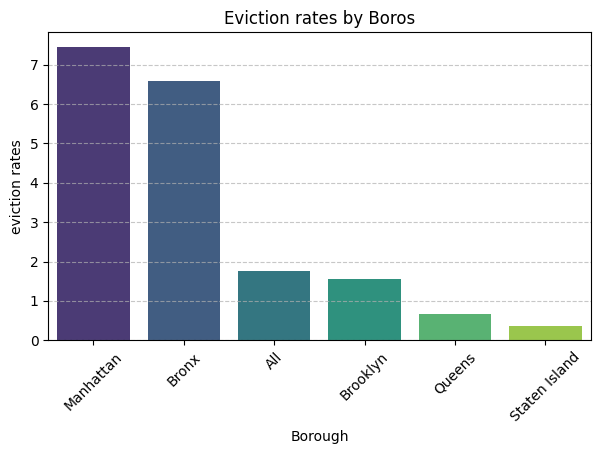

In [360]:
df_sorted = combined_count_evi_df.sort_values('total_eviction_rate', ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_sorted,
    x='borough',
    y='total_eviction_rate',
    palette='viridis'
)
plt.title('Eviction rates by Boros')
plt.xlabel('Borough')
plt.ylabel('eviction rates')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# will probably be better in excel

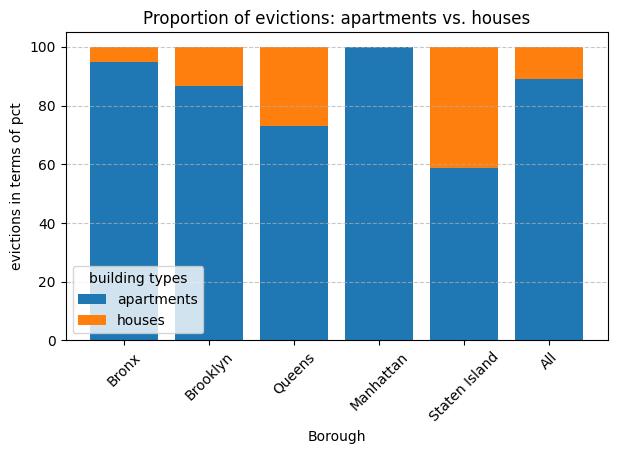

In [361]:
boroughs = combined_count_evi_df['borough']
apt_rates = combined_count_evi_df['evictions_apt_rate']
house_rates = combined_count_evi_df['evictions_house_rate']


plt.figure(figsize=(7, 4))
plt.bar(boroughs, apt_rates, label='apartments', color='#1f77b4')
plt.bar(boroughs, house_rates, bottom=apt_rates, label='houses', color='#ff7f0e')

plt.title('Proportion of evictions: apartments vs. houses')
plt.xlabel('Borough')
plt.ylabel('evictions in terms of pct')
plt.legend(title='building types')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# will probably be better in excel

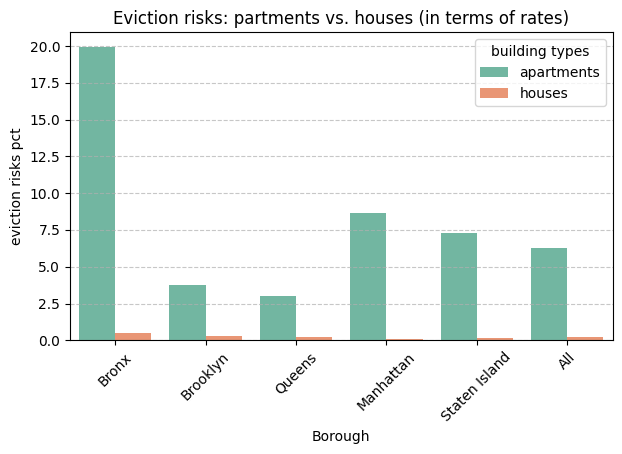

In [362]:
# in terms of eviction percentages (risks)
df_risk = combined_count_evi_df.melt(
    id_vars=['borough'],
    value_vars=['apt_with_eviction_rate', 'house_with_eviction_rate'],
    var_name='type',
    value_name='eviction_risk'
)

df_risk['type'] = df_risk['type'].replace({
    'apt_with_eviction_rate': 'apartments',
    'house_with_eviction_rate': 'houses'
})

plt.figure(figsize=(7, 4))
sns.barplot(
    data=df_risk,
    x='borough',
    y='eviction_risk',
    hue='type',
    palette='Set2'
)
plt.title('Eviction risks: partments vs. houses (in terms of rates)')
plt.xlabel('Borough')
plt.ylabel('eviction risks pct')
plt.legend(title='building types')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()